In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from gengraph import EpsimGraph
from epsim import Epsim

In [2]:
# Simple run

starttime = time.time()
epsim_graph = EpsimGraph(k=100000, sigma_office=0.5, perc_split_classes=0.5)
sim = Epsim()
sim.init_from_dicts(epsim_graph.family_nbrs, epsim_graph.school_nbrs_standard,
                    epsim_graph.school_nbrs_split, epsim_graph.office_nbrs)
sim.run_sim(sim_iters=200, p_spread_family=0.37, p_spread_school_office=0.2, p_detect_child=0.2,
            p_detect_parent=0.5, p_testing=0.5, print_progress=True, export_csv=False)
print(f"runtime: {time.time() - starttime}s".

creating graph with k=100000, sigma_office=0.5
randomly cluster children and parent nodes, such that there are child-parent pairs
parents: 1/2 no change, 1/4 merge 2 nodes, 1/8 merge 3 nodes, ...
parents: duplicate every node
children: k/l^2 many l*l grids, place l^2 nodes randomly on grid, cluster 8 neighbourhood, with l=5
50000 children in split classes and 50000 children in standard classes (100000 total, break: 2000)
parents: cluster 1-sigma_office no change, sigma_office*1/2 cluster 2 nodes, sigma_office*1/4 cluster 3 nodes, sigma_office*1/8 cluster 4 nodes, sigma_office*1/8 cluster 5 nodes
starting simulation with n=238640, num_start_nodes=24, sim_iters=200
p_spread_family=0.37, p_spread_school_office=0.2, p_detect_child=0.2, p_detect_parent=0.5 p_testing=0.5
family_nbrs: 238640, school_nbrs_standard: 50000, school_nbrs_split: 24000 26000, office_nbrs: 69320
0:	[238616, 0, 24, 0, 0, 0]	[0, 0, 0, 0, 0]
1:	[238616, 0, 0, 24, 0, 0]	[0, 0, 0, 0, 0]
2:	[238577, 28, 0, 0, 23, 12]	[18, 

In [2]:
# Multiple runs per parameter combination
num_runs = 100

sim_iters = 500
k = 100000
sigma_office_vals = [0.5]
p_spread_family_vals = [0.3]
p_spread_school_office_vals = [0.2]
p_detect_child_vals = [0.2]
p_detect_parent_vals = [0.5]
p_testing_vals = [0.5]
perc_split_classes_vals = [0.5]

runs_per_param_combi = {}
for sigma_office in sigma_office_vals:
    for p_spread_family in p_spread_family_vals:
        for p_spread_school_office in p_spread_school_office_vals:
            for p_detect_child in p_detect_child_vals:
                for p_detect_parent in p_detect_parent_vals:
                    for p_testing in p_testing_vals:
                        for perc_split_classes in perc_split_classes_vals:
                            runs = []
                            for i in range(num_runs):
                                epsim_graph = EpsimGraph(k, sigma_office, perc_split_classes)
                                sim = Epsim()
                                sim.init_from_dicts(epsim_graph.family_nbrs, epsim_graph.school_nbrs_standard,
                                                    epsim_graph.school_nbrs_split, epsim_graph.office_nbrs)
                                sim_res = sim.run_sim(sim_iters, p_spread_family, p_spread_school_office, 
                                                      p_detect_child, p_detect_parent, p_testing)
                                runs.append(sim_res[1])
                                param_combi = (sigma_office, p_spread_family, p_spread_school_office, p_detect_child,
                                               p_detect_parent, p_testing, p_spread_school_office)
                            runs_per_param_combi[param_combi] = runs

pickle.dump(runs_per_param_combi, open("runs_per_param_combi.p", 'wb'))

lasses
infected nodes: 358

creating graph with k=100000, sigma_office=0.5
randomly cluster children and parent nodes, such that there are child-parent pairs
parents: 1/2 no change, 1/4 merge 2 nodes, 1/8 merge 3 nodes, ...
parents: duplicate every node
children: k/l^2 many l*l grids, place l^2 nodes randomly on grid, cluster 8 neighbourhood, with l=5
	50000 children in split classes and 50000 children in standard classes (100000 total, break: 2000)
parents: cluster 1-sigma_office no change, sigma_office*1/2 cluster 2 nodes, sigma_office*1/4 cluster 3 nodes, sigma_office*1/8 cluster 4 nodes, sigma_office*1/8 cluster 5 nodes
starting simulation with n=238640, num_start_nodes=24, sim_iters=500
p_spread_family=0.3, p_spread_school_office=0.2, p_detect_child=0.2, p_detect_parent=0.5 p_testing=0.5
50000 children in split classes and 50000 children in standard classes
infected nodes: 9665

creating graph with k=100000, sigma_office=0.5
randomly cluster children and parent nodes, such that th

(sigma_office, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent, p_testing, p_spread_school_office)
(0.5, 0.3, 0.2, 0.2, 0.5, 0.5, 0.2)


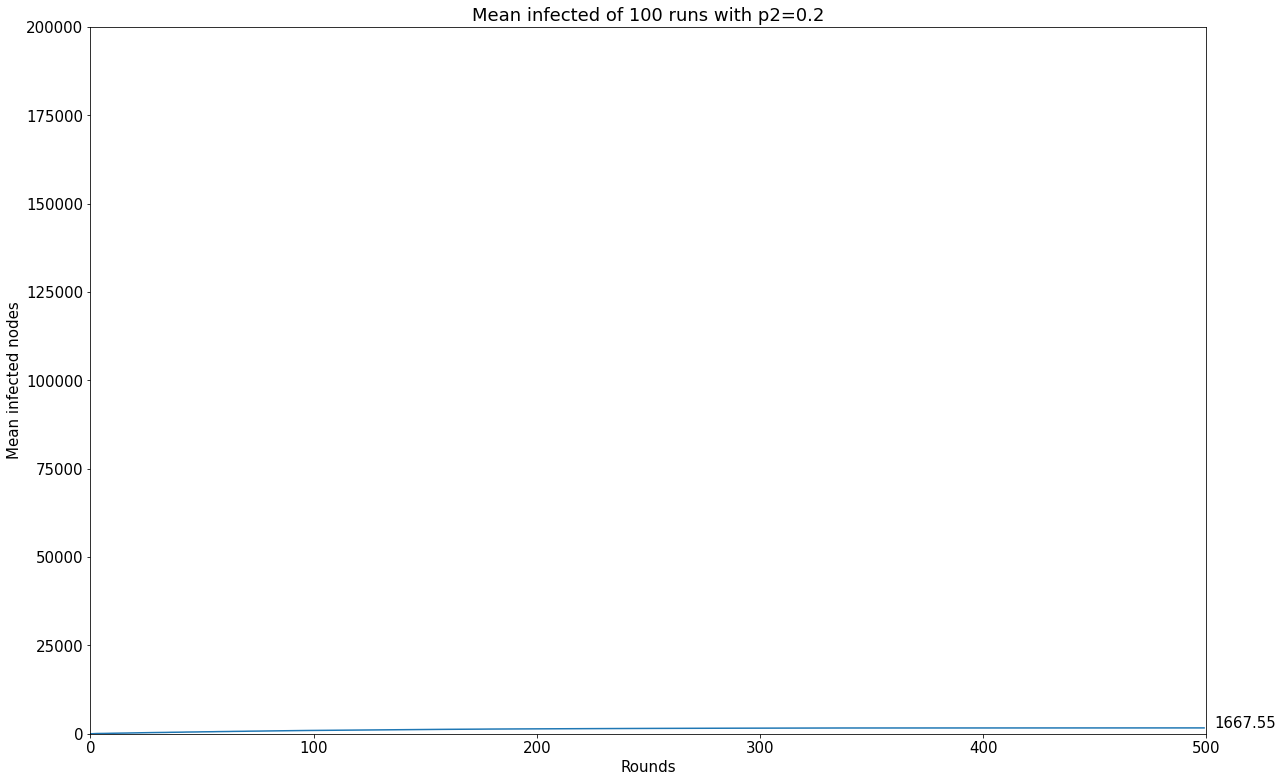

In [3]:
# Plot mean infections per round for all runs

plt.rcParams.update({'font.size': 15})

for param_combi, runs in runs_per_param_combi.items():
    print(param_combi)
    infecs_per_runs_per_rounds = zip(*runs)
    mean_infecs_per_round = [np.mean(infecs_per_runs) for infecs_per_runs in infecs_per_runs_per_rounds]
    fig, axs = plt.subplots(figsize=(20,13))
    fig.patch.set_facecolor('xkcd:white')
    axs.set_ylim(top=200000)
    axs.set_xlim(0, sim_iters)
    axs.plot(range(sim_iters), mean_infecs_per_round)
    plt.annotate(max(mean_infecs_per_round), xy=(1, max(mean_infecs_per_round)), xytext=(8, 0),
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    axs.set_title("Mean infected of 100 runs with p2=0.2")
    axs.set_xlabel("Rounds")
    axs.set_ylabel("Mean infected nodes")

(sigma_office, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent, p_testing, p_spread_school_office)
(0.5, 0.3, 0.2, 0.2, 0.5, 0.5, 0.2)


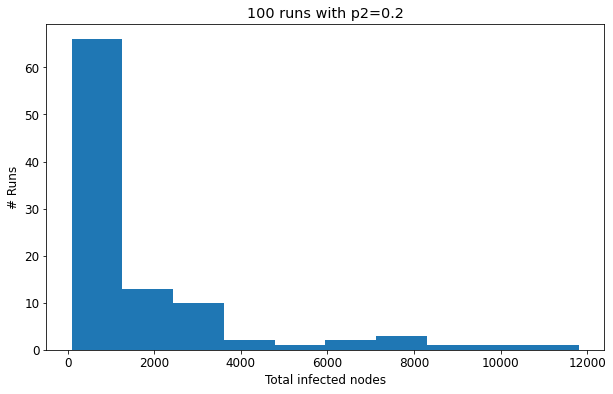

In [4]:
# Plot histogram of total infections for all runs

plt.rcParams.update({'font.size': 12})

for param_combi, runs in runs_per_param_combi.items():
    print(param_combi)
    total_infec_per_run = [max(run) for run in runs]
    fig, axs = plt.subplots(figsize=(10,6))
    fig.patch.set_facecolor('xkcd:white')
    axs.set_title("100 runs with p2=0.2")
    axs.set_xlabel("Total infected nodes")
    axs.set_ylabel("# Runs")
    axs.hist(total_infec_per_run)

In [3]:
# Run with various parameters

sim_iters = 500
k = 100000
sigma_office_vals = [0.5]
p_spread_family_vals = [0.3, 0.37]
p_spread_school_office_vals = [0.2, 0.22, 0.24]
p_detect_child_vals = [0.2]
p_detect_parent_vals = [0.5]
p_testing_vals = [0.5]
perc_split_classes = 0.5

results = {}

starttime = time.time()
for sigma_office in sigma_office_vals:
    epsim_graph = EpsimGraph(k, sigma_office, perc_split_classes)
    sim = Epsim()
    sim.init_from_dicts(epsim_graph.family_nbrs, epsim_graph.school_nbrs_standard,
                        epsim_graph.school_nbrs_split, epsim_graph.office_nbrs)
    for p_spread_family in p_spread_family_vals:
        for p_detect_child in p_detect_child_vals:
            for p_detect_parent in p_detect_parent_vals:
                for p_testing in p_testing_vals:
                    for p_spread_school_office in p_spread_school_office_vals:
                        export_csv = Path(f'csv/p1_{p_spread_family}_p2_{p_spread_school_office}.csv')
                        sim_res = sim.run_sim(sim_iters, p_spread_family, p_spread_school_office, p_detect_child,
                                              p_detect_parent, p_testing, export_csv=export_csv)
                        results[sigma_office, p_spread_family, p_detect_child, p_detect_parent, \
                                p_testing, p_spread_school_office] = sim_res

print(f"runtime: {time.time() - starttime}s")

creating graph with k=100000, sigma_office=0.5
randomly cluster children and parent nodes, such that there are child-parent pairs
parents: 1/2 no change, 1/4 merge 2 nodes, 1/8 merge 3 nodes, ...
parents: duplicate every node
children: k/l^2 many l*l grids, place l^2 nodes randomly on grid, cluster 8 neighbourhood, with l=5
50000 children in split classes and 50000 children in standard classes (100000 total, break: 2000)
parents: cluster 1-sigma_office no change, sigma_office*1/2 cluster 2 nodes, sigma_office*1/4 cluster 3 nodes, sigma_office*1/8 cluster 4 nodes, sigma_office*1/8 cluster 5 nodes
starting simulation with n=238640, num_start_nodes=24, sim_iters=500
p_spread_family=0.3, p_spread_school_office=0.2, p_detect_child=0.2, p_detect_parent=0.5 p_testing=0.5
family_nbrs: 238640, school_nbrs_standard: 50000, school_nbrs_split: 24000 26000, office_nbrs: 69320
infected nodes: 138

starting simulation with n=238640, num_start_nodes=24, sim_iters=500
p_spread_family=0.3, p_spread_scho

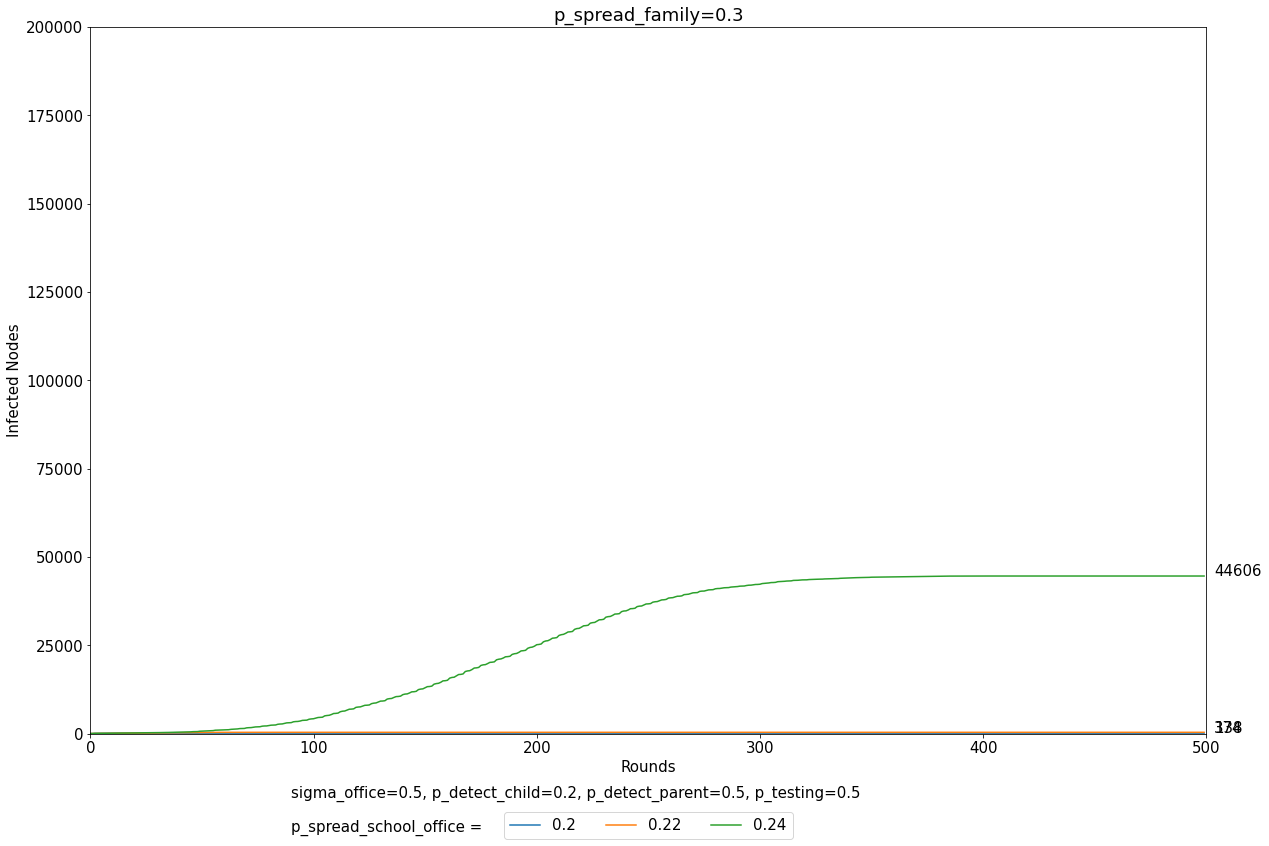

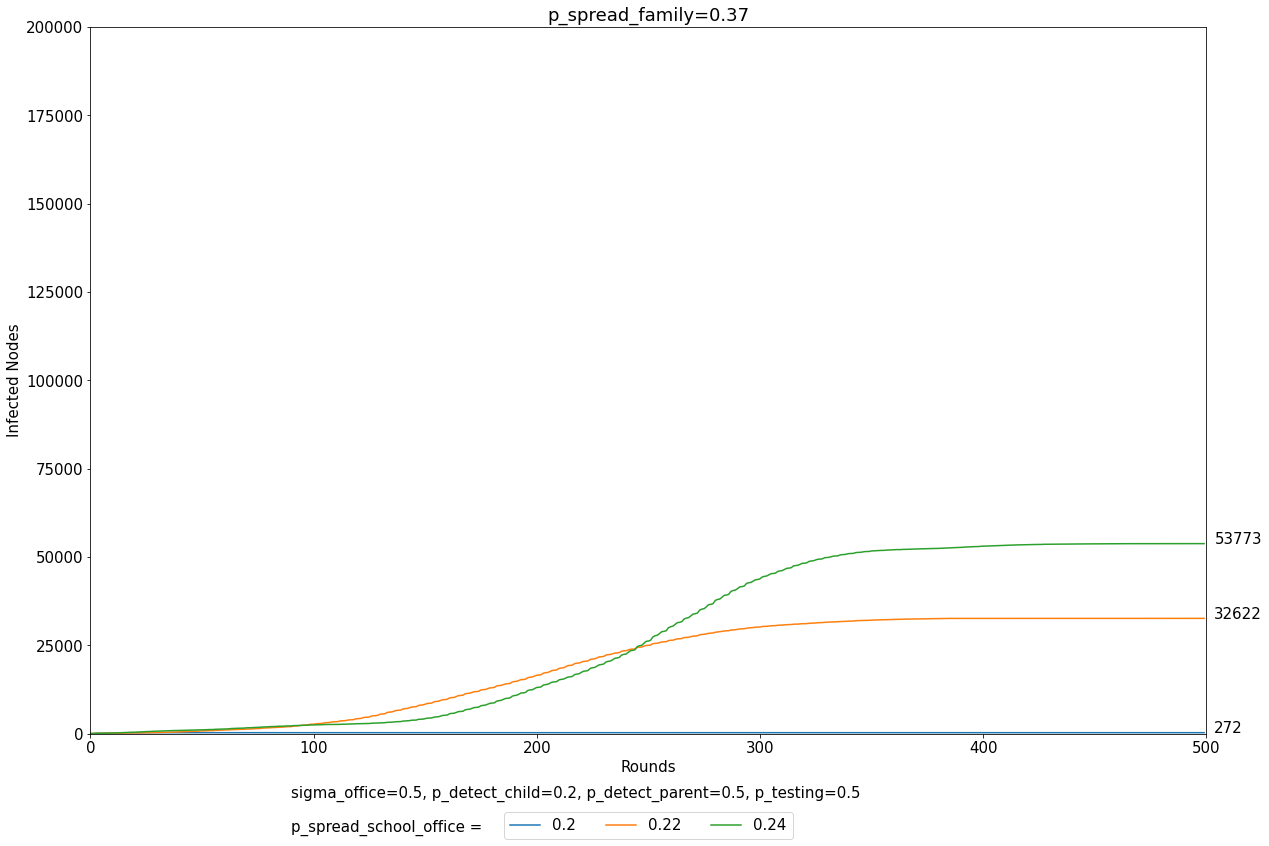

In [5]:
# Plot various parameter runs

plt.rcParams.update({'font.size': 15})

for sigma_office in sigma_office_vals:
    for p_spread_family in p_spread_family_vals:
        for p_detect_child in p_detect_child_vals:
            for p_detect_parent in p_detect_parent_vals:
                for p_testing in p_testing_vals:
                    fig, axs = plt.subplots(figsize=(20,13))
                    fig.patch.set_facecolor('xkcd:white')
                    axs.set_ylim(top=200000)
                    axs.set_xlim(0, sim_iters)
                    for p_spread_school_office in p_spread_school_office_vals:
                        result = results[sigma_office, p_spread_family, p_detect_child, p_detect_parent, \
                                         p_testing, p_spread_school_office]
                        axs.plot(result[0], result[1], label=p_spread_school_office)
                        plt.annotate(max(result[1]), xy=(1, max(result[1])), xytext=(8, 0),
                                     xycoords=('axes fraction', 'data'), textcoords='offset points')
                    axs.set_title(f"p_spread_family={p_spread_family}")
                    axs.set_xlabel("Rounds")
                    axs.set_ylabel("Infected Nodes")
                    text_fixed = f"sigma_office={sigma_office}, p_detect_child={p_detect_child}, \
                                   p_detect_parent={p_detect_parent}, p_testing={p_testing}"
                    axs.text(0.18, -0.09, text_fixed, transform=axs.transAxes)
                    axs.text(0.18, -0.138, 'p_spread_school_office =', transform=axs.transAxes)                   
                    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)